<a href="https://colab.research.google.com/github/lorenz0leoncin1/Tree-predictors-mushroom-classification/blob/main/Hyper_FS_Tree_predictors_for_binary_classification_mushrooms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 1: Import libraries & dataset

In [ ]:
# Install necessary packages
!pip3 install -U ucimlrepo
!pip3 install -U scikit-learn

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, ClassifierMixin


In [ ]:
# fetch dataset
secondary_mushroom = fetch_ucirepo(id=848)

# data (as pandas dataframes)
X = secondary_mushroom.data.features
y = secondary_mushroom.data.targets

In [ ]:
X.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


In [ ]:
y.head()

,class
0,p
1,p
2,p
3,p
4,p


In [ ]:
print(X.shape)
print(y.shape)

(61069, 20)
(61069, 1)


# Phase 2: Data pre-processing

In [ ]:
# Check for missing values
missing_values = X.isnull().sum()
print("Missing values per feature:\n", missing_values)

Missing values per feature:
 cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64


In [ ]:
# Threshold for dropping columns with too many missing values (e.g., more than 50%)
threshold = 0.5 * len(X)  # 50% of total rows
X_dropped = X.drop(columns=[col for col in X.columns if X[col].isnull().sum() > threshold])
print("Dataset after removing columns with too many missing values:\n", X_dropped.head())

Dataset after removing columns with too many missing values:
    cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0         15.26         x           g         o                    f   
1         16.60         x           g         o                    f   
2         14.07         x           g         o                    f   
3         14.17         f           h         e                    f   
4         14.64         x           h         o                    f   

  gill-attachment gill-spacing gill-color  stem-height  stem-width stem-color  \
0               e          NaN          w        16.95       17.09          w   
1               e          NaN          w        17.99       18.19          w   
2               e          NaN          w        17.80       17.74          w   
3               e          NaN          w        15.77       15.98          w   
4               e          NaN          w        16.53       17.20          w   

  has-ring ring-ty

In [ ]:
# Checking missing values
missing_values_dropped = X_dropped.isnull().sum()
print("Missing values per feature dopo la rimozione delle colonne:\n", missing_values_dropped)

# columns dtypes
print("Columns dtypes:\n", X_dropped.dtypes)


Missing values per feature dopo la rimozione delle colonne:
 cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-color                  0
has-ring                    0
ring-type                2471
habitat                     0
season                      0
dtype: int64
Columns dtypes:
 cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-color               object
has-ring                 object
ring-type                object
habitat                  object
season     

In [ ]:
# Fill missing values in object-type columns with 'unknown'
object_cols = X_dropped.select_dtypes(include=['object']).columns
X_dropped[object_cols] = X_dropped[object_cols].fillna('unknown')

# Check the result
missing_values_after_fill = X_dropped.isnull().sum()
print("Missing values after filling:\n", missing_values_after_fill)


Missing values after filling:
 cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64


In [ ]:
# Define categorical and numerical columns
categorical_cols = X_dropped.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_dropped.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),  # Keep numerical columns as is
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)  # Apply OneHotEncoding to categorical columns
    ]
)


# Phase 3: Creating class Node


In [ ]:
class Node:
    def __init__(self, split_criterion=None, is_leaf=False, prediction=None):
        """
        Initializes the node.
        :param split_criterion: Function that decides the split based on a feature
        :param is_leaf: Boolean flag to check if the node is a leaf
        :param prediction: Predicted value if the node is a leaf
        """
        self.split_criterion = split_criterion  # Function for splitting decision
        self.is_leaf = is_leaf  # Indicates if the node is a leaf
        self.prediction = prediction  # Predicted value if it's a leaf
        self.left_child = None  # Left child node
        self.right_child = None  # Right child node

    def apply_split(self, data_point):
        """
        Applies the split criterion to a data point.
        :param data_point: A row of data (sample) to test
        :return: True if the sample should go to the left, False if to the right
        """
        if self.split_criterion is None:
            raise ValueError("Split criterion is not defined.")

        # Apply the split function to the data point
        return self.split_criterion(data_point)

    def set_children(self, left_child, right_child):
        """
        Assigns the left and right children to the current node.
        :param left_child: Left child node
        :param right_child: Right child node
        """
        self.left_child = left_child
        self.right_child = right_child


#Phase 4: Creating Class TreePredictor

In [ ]:
class TreePredictor(BaseEstimator, ClassifierMixin):
    def __init__(self, split_criterion_func, max_depth=None, min_samples_split=2, min_impurity_decrease=0.0):
        """
        Initializes the decision tree.
        """
        self.split_criterion_func = split_criterion_func  # Function used for calculating impurity
        self.max_depth = max_depth  # Maximum depth of the tree
        self.min_samples_split = min_samples_split  # Minimum number of samples required to split a node
        self.min_impurity_decrease = min_impurity_decrease  # Minimum impurity decrease required to make a split
        self.root = None  # Root node of the tree
        self.feature_names_ = None  # Names of the features
        self.classes_ = None  # Store the unique classes

    def fit(self, X, y):
        """
        Trains the decision tree.
        :param X: Feature matrix
        :param y: Target vector
        """
        if hasattr(X, 'columns'):
            self.feature_names_ = X.columns  # Extract feature names from DataFrame
        elif isinstance(X, np.ndarray):
            self.feature_names_ = [f"feature_{i}" for i in range(X.shape[1])]  # Generate default feature names
        else:
            raise ValueError("Input X must be a pandas DataFrame or a NumPy array.")  # Error if input is invalid

        self.classes_ = np.unique(y)  # Store the unique classes
        self.root = self._grow_tree(X, y, depth=0)  # Build the tree starting from the root

    def _grow_tree(self, X, y, depth):
        """
        Recursively grows the decision tree.
        :param X: Feature matrix
        :param y: Target vector
        :param depth: Current depth of the tree
        :return: Node of the decision tree
        """
        num_samples, num_features = X.shape  # Get the number of samples and features
        current_impurity = self.split_criterion_func(y)  # Calculate current impurity

        # Check stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or \
           num_samples < self.min_samples_split or \
           len(set(y)) == 1:  # If stopping criteria met, create a leaf node
            leaf_value = self._most_common_label(y)  # Get the most common label
            return Node(is_leaf=True, prediction=leaf_value)

        # Find the best split
        best_feature, best_threshold, best_impurity = self._best_split(X, y)

        # If no valid split is found, create a leaf node
        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return Node(is_leaf=True, prediction=leaf_value)

        # Calculate impurity decrease
        impurity_decrease = current_impurity - best_impurity

        # Check if impurity decrease meets the minimum requirement
        if impurity_decrease < self.min_impurity_decrease:
            leaf_value = self._most_common_label(y)
            return Node(is_leaf=True, prediction=leaf_value)

        # Split the data
        left_indices, right_indices = self._split(X[:, best_feature], best_threshold)
        left_child = self._grow_tree(X[left_indices, :], y[left_indices], depth + 1)  # Grow left subtree
        right_child = self._grow_tree(X[right_indices, :], y[right_indices], depth + 1)  # Grow right subtree

        # Create an internal node
        node = Node(split_criterion=lambda data_point: data_point[best_feature] <= best_threshold)
        node.set_children(left_child, right_child)  # Set the children nodes
        return node

    def _best_split(self, X, y):
        """
        Finds the best split based on impurity criterion.
        :param X: Feature matrix
        :param y: Target vector
        :return: Best feature index, best threshold, and best impurity
        """
        best_feature = None  # Initialize best feature
        best_threshold = None  # Initialize best threshold
        best_impurity = float('inf')  # Initialize best impurity to infinity

        current_impurity = self.split_criterion_func(y)  # Calculate current impurity

        # Iterate through each feature to find the best split
        for feature_index in range(X.shape[1]):
            feature_column = X[:, feature_index]  # Get the current feature column
            thresholds = np.unique(feature_column)  # Get unique thresholds for the feature
            for threshold in thresholds:
                # Split the data based on the threshold
                left_indices, right_indices = self._split(feature_column, threshold)
                if len(left_indices) == 0 or len(right_indices) == 0:  # Skip if split is not valid
                    continue

                # Calculate impurity for both splits
                left_impurity = self.split_criterion_func(y[left_indices])
                right_impurity = self.split_criterion_func(y[right_indices])

                # Calculate the weighted total impurity
                impurity = (len(left_indices) / len(y)) * left_impurity + \
                           (len(right_indices) / len(y)) * right_impurity

                # Update the best split if the impurity is lower
                if impurity < best_impurity:
                    best_impurity = impurity
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold, best_impurity  # Return the best split details

    def _split(self, feature_column, threshold):
        """
        Splits the data into left and right groups based on the threshold.
        :param feature_column: A feature column
        :param threshold: Threshold value for splitting
        :return: Indices of left and right groups
        """
        # Check if feature_column is already a dense array
        if not isinstance(feature_column, np.ndarray):
            feature_column = feature_column.toarray().flatten()  # Convert to dense array if needed

        # Perform the split
        left_indices = np.where(feature_column <= threshold)[0]  # Indices for left split
        right_indices = np.where(feature_column > threshold)[0]  # Indices for right split
        return left_indices, right_indices

    def _calculate_impurity(self, left_y, right_y):
        """
        Calculates the impurity of a split (e.g., Gini index or entropy).
        :param left_y: Target values for the left group
        :param right_y: Target values for the right group
        :return: Impurity of the split
        """
        left_weight = len(left_y) / (len(left_y) + len(right_y))  # Calculate left group weight
        right_weight = 1 - left_weight  # Calculate right group weight

        # You can use Gini index, entropy, or other criteria
        impurity = left_weight * self.split_criterion_func(left_y) + right_weight * self.split_criterion_func(right_y)  # Calculate weighted impurity
        return impurity

    def _most_common_label(self, y):
        """
        Returns the most common label in the target vector.
        Assumes y contains numeric labels (0 or 1).
        :param y: Target vector
        :return: Most common label
        """
        # Get the unique labels and their counts
        unique_labels, counts = np.unique(y, return_counts=True)

        # Find the index of the most frequent label
        most_frequent_index = np.argmax(counts)

        # Get the actual label value using the index
        most_frequent_label = unique_labels[most_frequent_index]

        return most_frequent_label  # Return the most common label

    def predict(self, X):
        """
        Predicts the class for each sample in the dataset.
        :param X: Feature matrix (numpy array)
        :return: Predicted classes
        """
        return [self._predict_sample(x) for x in X]  # Predict for each sample

    def _predict_sample(self, x):
        """
        Predicts the class for a single sample.
        :param x: Single data point (numpy array)
        :return: Predicted class
        """
        node = self.root  # Start from the root node
        while not node.is_leaf:  # Traverse the tree until a leaf node is reached
            if node.apply_split(x):  # Check which child to go to based on the split
                node = node.left_child
            else:
                node = node.right_child
        return node.prediction  # Return the prediction from the leaf node

    def score(self, X, y):
        """
        Calculates the accuracy of the predictions.
        :param X: Feature matrix (numpy array)
        :param y: Target vector
        :return: Model accuracy
        """
        predictions = self.predict(X)  # Get predictions
        return np.mean(predictions == y)  # Calculate accuracy

    def get_params(self, deep=True):
        """Get parameters for this estimator."""
        return {
            'split_criterion_func': self.split_criterion_func,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_impurity_decrease': self.min_impurity_decrease
        }

    def set_params(self, **parameters):
        """Set the parameters of this estimator."""
        for parameter, value in parameters.items():
            setattr(self, parameter, value)  # Update each parameter
        return self  # Return self for consistency


#Phase 5: Train the tree predictors adopting at least 3 reasonable criteria for the expansion of the leaves

In [ ]:
def gini_index(y):
    """Calculate Gini Index for a given array of labels."""
    m = len(y)
    if m == 0:
        return 0
    p = np.bincount(y) / m
    return 1 - np.sum(p ** 2)

def entropy(y):
    """Calculate Entropy for a given array of labels."""
    m = len(y)
    if m == 0:
        return 0
    p = np.bincount(y) / m
    return -np.sum(p * np.log2(p + 1e-10))  # Add small constant to avoid log(0)

def classification_error(y):
    """Calculate the Classification Error for an array of labels."""
    m = len(y)
    if m == 0:
        return 0
    p = np.bincount(y) / m
    return 1 - np.max(p)

In [ ]:
def train_and_evaluate(X_train, y_train, X_test, y_test):
    """
    Trains and evaluates the tree predictor with different criteria.
    :param X_train: Training feature matrix
    :param y_train: Training target vector
    :param X_test: Testing feature matrix
    :param y_test: Testing target vector
    """
    criteria = [gini_index, entropy, classification_error]
    for criterion in criteria:
        print(f"Training criteria: {criterion.__name__}")
        tree = TreePredictor(
            split_criterion_func=criterion,
            max_depth=5,
            min_samples_split=2,
            min_impurity_decrease=0.01
        )
        tree.fit(X_train, y_train)

        # Calcolo delle predizioni e dell'errore di training
        train_predictions = tree.predict(X_train)
        train_error = np.mean(train_predictions != y_train)
        print(f"Training Error: {train_error:.4f}")

        # Calcolo delle predizioni e dell'errore di test
        test_predictions = tree.predict(X_test)
        test_error = np.mean(test_predictions != y_test)
        print(f"Training Error: {test_error:.4f}\n")

In [ ]:
# Hyperparameter tuning function

def hyperparameter_tuning(X, y, criterion, param_grid, cv=5):
    """
    Performs hyperparameter optimization for the decision tree.
    :param X: Feature matrix
    :param y: Target vector
    :param criterion: Function used to evaluate impurity
    :param param_grid: Dictionary containing hyperparameters and their respective ranges
    :param cv: Number of cross-validation folds
    :return: Best parameters and best score achieved
    """
    best_score = float('inf')  # Initialize best score to infinity
    best_params = None  # Variable to store best parameters

    # Generate all combinations of parameters
    keys, values = zip(*param_grid.items())  # Unzip parameter grid into keys and values
    for instance in product(*values):  # Iterate over all combinations of parameter values
        params = dict(zip(keys, instance))  # Create a dictionary of parameters for the current combination
        scores = []  # List to store scores for each fold

        # Set up cross-validation
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)  # Initialize KFold cross-validation
        for train_index, val_index in kf.split(X):  # Split data into training and validation sets
            X_train_cv, X_val_cv = X[train_index], X[val_index]  # Create training and validation sets
            y_train_cv, y_val_cv = y[train_index], y[val_index]  # Corresponding target vectors

            # Initialize and train the decision tree
            tree = TreePredictor(
                split_criterion_func=criterion,  # Set impurity evaluation function
                max_depth=params['max_depth'],  # Set maximum depth of the tree
                min_samples_split=params['min_samples_split'],  # Set minimum samples required to split a node
                min_impurity_decrease=params['min_impurity_decrease']  # Set minimum impurity decrease to split
            )
            tree.fit(X_train_cv, y_train_cv)  # Fit the tree to the training data

            # Predict and calculate the error
            predictions = tree.predict(X_val_cv)  # Get predictions for the validation set
            error = np.mean(predictions != y_val_cv)  # Calculate error as the mean of misclassified samples
            scores.append(error)  # Append the error to the scores list

        avg_score = np.mean(scores)  # Calculate average score across all folds
        print(f"Parameters: {params}, CV Error: {avg_score:.4f}")  # Print parameters and error

        if avg_score < best_score:  # Check if the current average score is better than the best score
            best_score = avg_score  # Update best score
            best_params = params  # Update best parameters

    print(f"\nBest parameters: {best_params}, Best CV Error: {best_score:.4f}")  # Print the best parameters and score
    return best_params, best_score  # Return the best parameters and best score


#Phase 6: Hyperparameter tuning, results and confusion matrix

In [ ]:
# Assuming X_dropped and y are already defined

# Convert labels to numeric values
le = LabelEncoder()
y_numeric = le.fit_transform(y.to_numpy().ravel())

# Preprocess the dataset
X_train, X_test, y_train, y_test = train_test_split(X_dropped, y_numeric, test_size=0.2, random_state=42)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_impurity_decrease': [0.0, 0.01]
}

# List of split criteria for hyperparameter tuning
split_criteria = [gini_index, entropy, classification_error]
results = {}

# Hyperparameter tuning for each criterion using RandomizedSearchCV
for criterion in split_criteria:
    print(f"Tuning hyperparameters for criterion: {criterion.__name__}")

    # Create a model and use RandomizedSearchCV
    tree = TreePredictor(split_criterion_func=criterion)
    random_search = RandomizedSearchCV(tree, param_distributions=param_grid, n_iter=5, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    random_search.fit(X_train_processed, y_train)

    best_params = random_search.best_params_
    best_score = random_search.best_score_
    results[criterion] = (best_params, best_score)
    print(f"Best params for {criterion.__name__}: {best_params}, CV Error: {1 - best_score:.4f}")

Tuning hyperparameters for criterion: gini_index
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params for gini_index: {'min_samples_split': 5, 'min_impurity_decrease': 0.0, 'max_depth': 5}, CV Error: 0.2844
Tuning hyperparameters for criterion: entropy
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params for entropy: {'min_samples_split': 5, 'min_impurity_decrease': 0.01, 'max_depth': 5}, CV Error: 0.2884
Tuning hyperparameters for criterion: classification_error
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params for classification_error: {'min_samples_split': 5, 'min_impurity_decrease': 0.0, 'max_depth': 5}, CV Error: 0.2478


In [ ]:
# Select the best criterion based on cross-validation results
best_criterion = min(results, key=lambda x: results[x][1])

# Train the final model using the best criterion
final_tree = TreePredictor(
    split_criterion_func=best_criterion,
    max_depth=results[best_criterion][0]['max_depth'],
    min_samples_split=results[best_criterion][0]['min_samples_split'],
    min_impurity_decrease=results[best_criterion][0]['min_impurity_decrease']
)
final_tree.fit(X_train_processed, y_train)

# Calculate training predictions and error
train_predictions = final_tree.predict(X_train_processed)
train_error = np.mean(train_predictions != y_train)
print(f"Training Error: {train_error:.4f}")

# Optional: Predict on test set and evaluate final model
test_predictions = final_tree.predict(X_test_processed)
test_error = np.mean(test_predictions != y_test)
print(f"Final Test Error: {test_error:.4f}")

Training Error: 0.2856
Final Test Error: 0.2895


Accuracy: 0.710496151956771
Confusion Matrix:
 [[4926  448]
 [3088 3752]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.92      0.74      5374
           1       0.89      0.55      0.68      6840

    accuracy                           0.71     12214
   macro avg       0.75      0.73      0.71     12214
weighted avg       0.77      0.71      0.70     12214



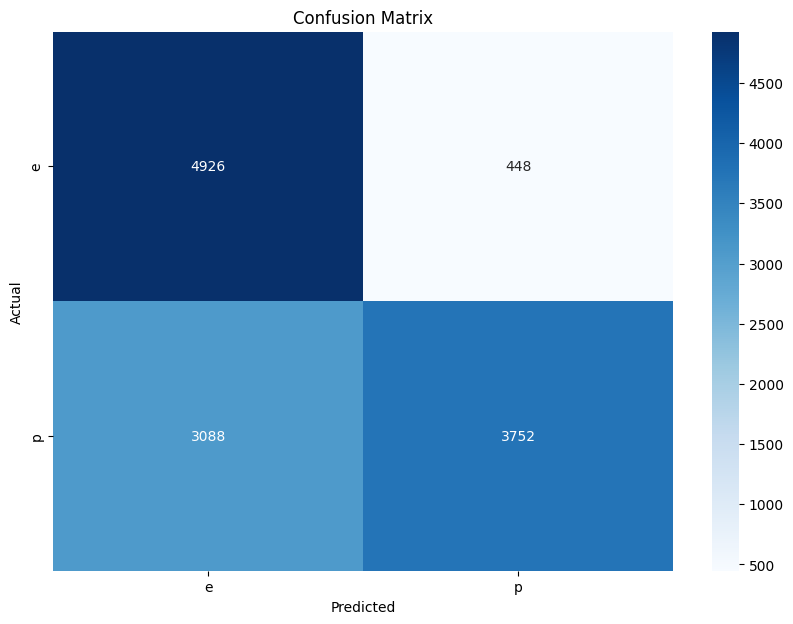

In [ ]:
# Make predictions
# Assuming 'final_tree' was the model trained with the best hyperparameters
y_pred = final_tree.predict(X_test_processed)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Optional: Visualizing the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()